실제 이탈률 (전체 데이터 대비): 0.006305420129137313

이탈자 연령 분포:
 count    106627.000000
mean         57.463166
std          21.624046
min           0.000000
25%          41.000000
50%          65.000000
75%          74.000000
max          96.000000
Name: AGE, dtype: float64

이탈자 성별 분포:
 SEX
2    0.51788
1    0.48212
Name: proportion, dtype: float64

이탈자 소득 분포:
 count    1.066270e+05
mean     2.945785e+05
std      1.500082e+06
min     -8.600000e+03
25%      1.900000e+04
50%      4.352000e+04
75%      8.000000e+04
max      9.999999e+06
Name: INCTOT, dtype: float64

이탈자 공보험 보유율:
HINSCAID HINSCAID
1.0    0.901751
2.0    0.098249
Name: proportion, dtype: float64
HINSCARE HINSCARE
2.0    0.512516
1.0    0.487484
Name: proportion, dtype: float64
HINSVA HINSVA
1.0    0.929821
2.0    0.070179
Name: proportion, dtype: float64

이탈자의 공보험 이동률:
     HINSCAID  HINSCARE  HINSVA
1.0     96151     51979   99144
2.0     10476     54648    7483


c:\Users\venus\anaconda3\envs\torch_env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\venus\anaconda3\envs\torch_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


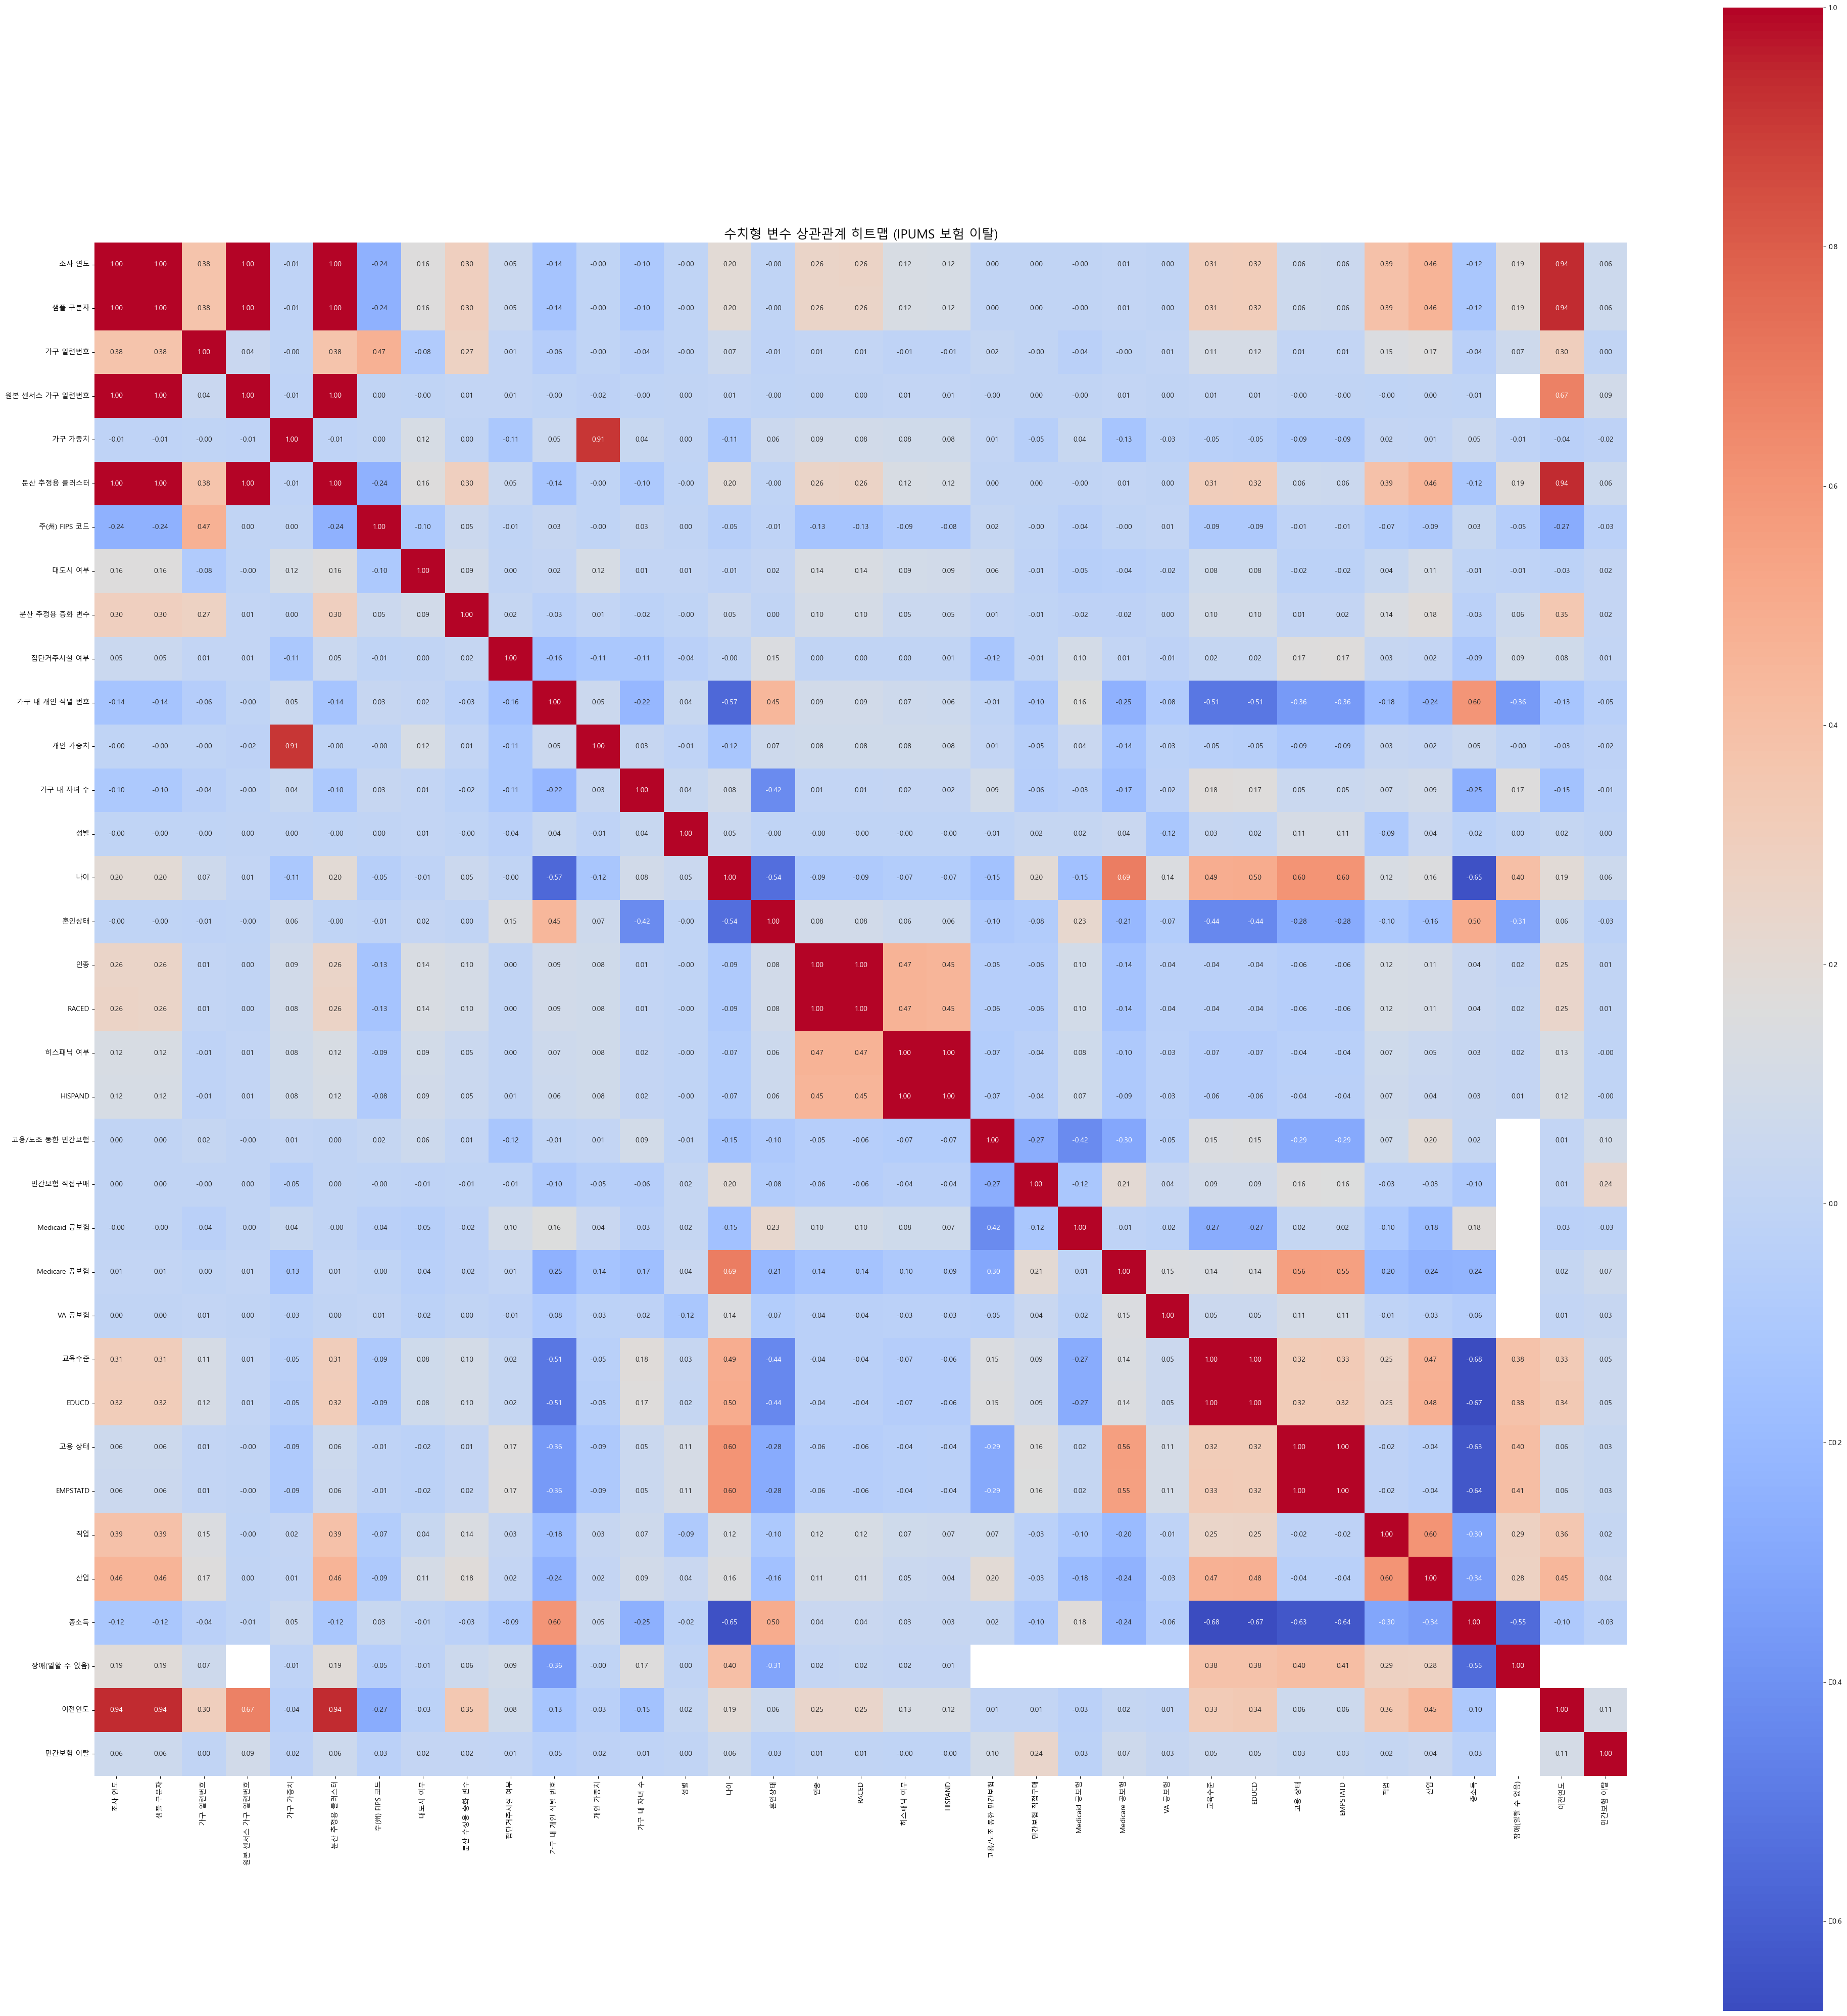

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import platform

# ========== [1. 한글 폰트 설정] ==========
plt.rc('font', family='Malgun Gothic')
# ========== [2. 컬럼명 영→한글 매핑] ==========
col_kor = {
    "YEAR": "조사 연도",
    "SAMPLE": "샘플 구분자", 'x'
    "SERIAL": "가구 일련번호",
    "CBSERIAL": "원본 센서스 가구 일련번호", 'x'
    "HHWT": "가구 가중치", '평균 가구원수 3명 ' '1인가구, 2인가구 3인구 다가구'
    "CLUSTER": "분산 추정용 클러스터", 
    "STRATA": "분산 추정용 층화 변수", 'x'
    "GQ": "집단거주시설 여부", 'x'
    "STATEFIP": "주(州) FIPS 코드",
    "METRO": "대도시 여부", '미국 동부 서부 중부 농사'
    "PERNUM": "가구 내 개인 식별 번호",
    "PERWT": "개인 가중치",
    "NCHILD": "가구 내 자녀 수",
    "SEX": "성별",
    "AGE": "나이",
    "MARST": "혼인상태",
    "RACE": "인종",
    "HISPAN": "히스패닉 여부", 'x'
    "HINSEMP": "고용/노조 통한 민간보험",
    "HINSPUR": "민간보험 직접구매",
    "HINSCAID": "Medicaid 공보험", 'x'
    "HINSCARE": "Medicare 공보험", 'x'
    "HINSVA": "VA 공보험", 'x'
    "EDUC": "교육수준", '교육보험'
    "EMPSTAT": "고용 상태",
    "OCC": "직업",
    "IND": "산업",
    "INCTOT": "총소득",
    "DISABWRK": "장애(일할 수 없음)",
    "HAS_PRIVATE": "민간보험 보유여부",
    "PREV_HAS_PRIVATE": "이전 민간보험 보유", '민간 -> 의약품' 
    "PREV_YEAR": "이전연도",
    "PRIVATE_CHURN": "민간보험 이탈"
}

# ========== [3. 데이터 전처리] ==========
df = pd.read_csv('./data/usa_00001.csv.gz')

df['PERSON_ID'] = df['SERIAL'].astype(str) + '_' + df['PERNUM'].astype(str) + '_' + df['STATEFIP'].astype(str)
df = df.sort_values(by=['PERSON_ID', 'YEAR'])

def has_private_insurance(row):
    return ((row['HINSEMP'] == 1) or (row['HINSPUR'] == 1))

df['HAS_PRIVATE'] = df.apply(has_private_insurance, axis=1)
df['PREV_HAS_PRIVATE'] = df.groupby('PERSON_ID')['HAS_PRIVATE'].shift(1)
df['PREV_YEAR'] = df.groupby('PERSON_ID')['YEAR'].shift(1)

df['PRIVATE_CHURN'] = (
    (df['PREV_HAS_PRIVATE'] == True) &
    (df['HAS_PRIVATE'] == False) &
    (df['YEAR'] == df['PREV_YEAR'] + 1)
).astype(int)

churn_df = df[df['PRIVATE_CHURN'] == 1]

print("실제 이탈률 (전체 데이터 대비):", df['PRIVATE_CHURN'].mean())
print("\n이탈자 연령 분포:\n", churn_df['AGE'].describe())
print("\n이탈자 성별 분포:\n", churn_df['SEX'].value_counts(normalize=True))
print("\n이탈자 소득 분포:\n", churn_df['INCTOT'].describe())
print("\n이탈자 공보험 보유율:")
for col in ['HINSCAID', 'HINSCARE', 'HINSVA']:
    print(col, churn_df[col].value_counts(normalize=True))
print("\n이탈자의 공보험 이동률:")
print(churn_df[['HINSCAID', 'HINSCARE', 'HINSVA']].apply(pd.Series.value_counts))

# ========== [4. 상관계수 행렬 + 컬럼명 한글 변경] ==========
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()

corr.index = [col_kor.get(c, c) for c in corr.index]
corr.columns = [col_kor.get(c, c) for c in corr.columns]

# ========== [5. 히트맵 시각화] ==========
plt.figure(figsize=(40, 40))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True, annot_kws={"fontsize":10})
plt.title("수치형 변수 상관관계 히트맵 (IPUMS 보험 이탈)", fontsize=18)
plt.tight_layout()
plt.show()



In [4]:
!pip install xgboost

In [5]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# ========== [1. 데이터 불러오기] ==========
df = pd.read_csv('./data/usa_00001.csv.gz')

# ========== [2. 민간보험 이탈 타깃 파생 ==========
# (이전 연도에는 보험 있었고, 현재는 없음, 연속된 연도) = 이탈
df['HAS_PRIVATE'] = (df['HINSEMP'] == 1) | (df['HINSPUR'] == 1)
df['PERSON_ID'] = df['SERIAL'].astype(str) + '_' + df['PERNUM'].astype(str) + '_' + df['STATEFIP'].astype(str)
df = df.sort_values(by=['PERSON_ID', 'YEAR'])
df['PREV_HAS_PRIVATE'] = df.groupby('PERSON_ID')['HAS_PRIVATE'].shift(1)
df['PREV_YEAR'] = df.groupby('PERSON_ID')['YEAR'].shift(1)
df['PRIVATE_CHURN'] = (
    (df['PREV_HAS_PRIVATE'] == True) &
    (df['HAS_PRIVATE'] == False) &
    (df['YEAR'] == df['PREV_YEAR'] + 1)
).astype(int)

# ========== [3. 주요 피처 및 타깃 선택 ==========
features = [
    'AGE', 'SEX', 'MARST', 'RACE', 'HISPAN', 'EDUC', 'EMPSTAT', 'GQ',
    'STATEFIP', 'METRO', 'NCHILD', 'INCTOT', 'HINSCAID', 'HINSCARE', 'HINSVA',
    'DISABWRK'
]
target = 'PRIVATE_CHURN'

# ========== [4. 결측치 제거 ==========
data = df[features + [target]].dropna()

# ========== [5. 범주형 변수 라벨 인코딩 ==========
categorical = ['SEX', 'MARST', 'RACE', 'HISPAN', 'EDUC', 'EMPSTAT', 'GQ', 'STATEFIP', 'METRO', 'DISABWRK']
for col in categorical:
    data[col] = LabelEncoder().fit_transform(data[col])

X = data[features]
y = data[target]

In [6]:
print("이탈 타깃 값(0/1) 분포:\n", y.value_counts())

이탈 타깃 값(0/1) 분포:
 Series([], Name: count, dtype: int64)


In [7]:
print("원본 샘플 수:", len(df))

원본 샘플 수: 16910372


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# ========== [1. 데이터 불러오기] ==========
df = pd.read_csv('./data/usa_00001.csv.gz')

# ========== [2. 민간보험 이탈 타깃 파생 ==========
df['HAS_PRIVATE'] = (df['HINSEMP'] == 1) | (df['HINSPUR'] == 1)
df['PERSON_ID'] = df['SERIAL'].astype(str) + '_' + df['PERNUM'].astype(str) + '_' + df['STATEFIP'].astype(str)
df = df.sort_values(by=['PERSON_ID', 'YEAR'])
df['PREV_HAS_PRIVATE'] = df.groupby('PERSON_ID')['HAS_PRIVATE'].shift(1)
df['PREV_YEAR'] = df.groupby('PERSON_ID')['YEAR'].shift(1)
df['PRIVATE_CHURN'] = (
    (df['PREV_HAS_PRIVATE'] == True) &
    (df['HAS_PRIVATE'] == False) &
    (df['YEAR'] == df['PREV_YEAR'] + 1)
).astype(int)

# ========== [3. 주요 피처 및 타깃 선택 ==========
features = [
    'AGE', 'SEX', 'MARST', 'RACE', 'HISPAN', 'EDUC', 'EMPSTAT', 'GQ',
    'STATEFIP', 'METRO', 'NCHILD', 'INCTOT', 'HINSCAID', 'HINSCARE', 'HINSVA',
    'DISABWRK'
]
target = 'PRIVATE_CHURN'

data = df[features + [target]].copy()

# ========== [4. 결측치 처리 ==========
numeric_cols = data[features].select_dtypes(include=['number']).columns
categorical_cols = [col for col in features if col not in numeric_cols]

# 수치형: 평균으로 채움
for col in numeric_cols:
    data[col] = data[col].fillna(data[col].mean())

# 범주형: 최빈값으로 채움
for col in categorical_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# ========== [5. 범주형 변수 라벨 인코딩 ==========
categorical = ['SEX', 'MARST', 'RACE', 'HISPAN', 'EDUC', 'EMPSTAT', 'GQ', 'STATEFIP', 'METRO', 'DISABWRK']
for col in categorical:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

X = data[features]
y = data[target]

# ========== [6. 이탈 타깃 분포 확인 ==========
print("이탈 타깃 값(0/1) 분포:\n", y.value_counts())
print(f"실제 이탈률 (전체 데이터 대비): {y.mean():.4f}")

# ========== [7. XGBoost DMatrix ==========
dtrain = xgb.DMatrix(X, label=y)

# ========== [8. XGBoost 파라미터 및 학습 ==========
if y.sum() == 0:
    raise ValueError("이탈자(타깃=1)가 없습니다! 타깃 파생식을 확인하세요.")
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': 42,
    'scale_pos_weight': (len(y)-y.sum())/y.sum()
}
bst = xgb.train(params, dtrain, num_boost_round=150)

# ========== [9. 컬럼명 영→한글 매핑 ==========
col_kor = {
    "AGE": "나이", "SEX": "성별", "MARST": "혼인상태", "RACE": "인종", "HISPAN": "히스패닉 여부",
    "EDUC": "교육수준", "EMPSTAT": "고용 상태", "GQ": "집단거주시설 여부", "STATEFIP": "주(州) FIPS 코드",
    "METRO": "대도시 여부", "NCHILD": "가구 내 자녀 수", "INCTOT": "총소득",
    "HINSCAID": "Medicaid 공보험", "HINSCARE": "Medicare 공보험", "HINSVA": "VA 공보험",
    "DISABWRK": "장애(일할 수 없음)"
}

# ========== [10. 피처임포턴스 시각화 ==========
plt.figure(figsize=(10, 7))
ax = xgb.plot_importance(
    bst, 
    height=0.7, 
    max_num_features=15,
    importance_type='gain', 
    xlabel='Feature Importance', 
    ylabel='Features'
)
labels = [col_kor.get(t.get_text(), t.get_text()) for t in ax.get_yticklabels()]
ax.set_yticklabels(labels, fontsize=12)
plt.title('XGBoost 피처임포턴스 (보험 이탈 예측)', fontsize=16)
plt.tight_layout()
plt.show()


In [1]:
print("원본 샘플 수:", len(df))

NameError: name 'df' is not defined